# Using the inference module

In [76]:
from inferencing import *
#example usage
record_clip(duration=2)






user_generated_recordings/app_recording.wav saved as 2 sec clip of size 32000


torch.Size([1, 32000]) padded to torch.Size([1, 160000]), clip inserted in position 0
Return Spectrogram of shape torch.Size([1, 151, 801])


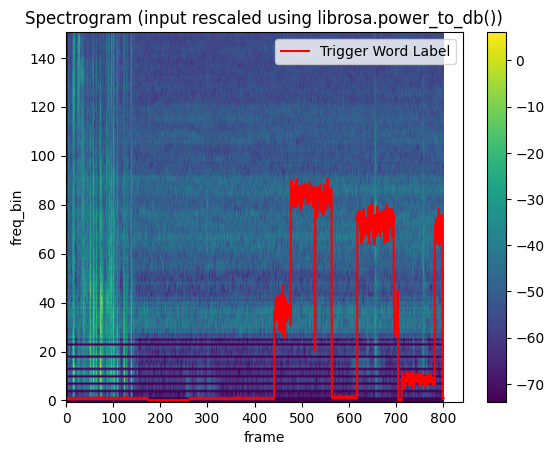

1.0036363636363637  seconds
2.0  seconds
3.0036363636363634  seconds
4.0  seconds
5.003636363636364  seconds
Chime - trigger word detected at 5.949090909090909 seconds, index 818
Chime - trigger word un detected detected at 5.949090909090909 seconds, index 818
Chime - trigger word detected at 5.956363636363636 seconds, index 819
6.0  seconds
Chime - trigger word un detected detected at 6.014545454545455 seconds, index 827
Chime - trigger word detected at 6.0218181818181815 seconds, index 828
Chime - trigger word un detected detected at 6.08 seconds, index 836
Chime - trigger word detected at 6.087272727272727 seconds, index 837
Chime - trigger word un detected detected at 6.218181818181818 seconds, index 855
Chime - trigger word detected at 6.225454545454546 seconds, index 856
Chime - trigger word un detected detected at 6.225454545454546 seconds, index 856
Chime - trigger word detected at 6.2327272727272724 seconds, index 857
Chime - trigger word un detected detected at 6.247272727272

In [77]:
play_clip(file ='user_generated_recordings/app_recording.wav')    

padded_waveform, rsr = pad_clip(file ='user_generated_recordings/app_recording.wav')

background = create_background()

#can weight the background sound - won't for now
bg_weight = 0.1
padded_waveform =padded_waveform + bg_weight*background

#play padded audio clip
Audio(padded_waveform.numpy()[0], rate=rsr,autoplay=False )

#convert to spectrogram
padded_spec = apply_spectrogram(padded_waveform,sample_rate =rsr)


#load model and perform inferencing
model = torch.load('model_test_mel_100_epochs')
label_out = model(padded_spec)


#graph label over spectrogram
# now graph 
plot_spectrogram(padded_spec[0],label_out.detach().numpy(), title=None, ylabel='freq_bin', aspect='auto', xmax=None)

real_time_detection(label_out,real_time=False) 

# Functionalising the below

In [49]:
# import required libraries
import sounddevice as sd
from scipy.io.wavfile import write
import wavio as wv
import time 
import torchaudio
from IPython.display import Audio
#play clip
import torch
import torchaudio.transforms as T

def record_clip(duration,max_length = 10, folder = 'user_generated_recordings/',sample_rate = 16000,   channels = 1,out_name ='app_recording.wav'):
    '''
    Function to record clip - must be 10 secs or less
    max_length - of clip size
    folder - locatoin to save clip
    sample_rate - sr of the clip - must be the same as the model (defaut 16k)
    channels - don't change this - defaults to 1 channel 
'''
    
    #ensure duration of clip is not larger than the max clip length that can be fed into the model
    if duration >max_length:
        duration = max_length
    
    rec_length = int(duration * sample_rate)  # clip length in array size not seconds
    
    # Start recorder with the given values
    # of duration and sample frequency
    recording = sd.rec(rec_length,
                   samplerate=sample_rate, channels=channels)

    # Record audio for the given number of seconds

    time.sleep(duration)

    # This will convert the NumPy array to an audio
    # file with the given sampling frequency

    
    #save clip
    file = folder+ out_name
    write(file, sample_rate, recording)
    
    print(f'{file} saved as {duration} sec clip of size {len(recording)}')
          


In [6]:
record_clip(duration=2)
    
def play_clip(file ='user_generated_recordings/app_recording.wav'):
    '''
    Play a given audio clip
    '''
    
    waveform, rsr  = torchaudio.load(file)
    return(Audio(waveform.numpy()[0], rate=rsr,autoplay=True ))
    
play_clip(file ='user_generated_recordings/app_recording.wav')    

NameError: name 'record_clip' is not defined

In [62]:
def pad_clip(file ='user_generated_recordings/app_recording.wav', offset =0,duration =10):
    '''
    Pad clip so it is the correct length to convert into a spectrogram to insert into the model
    for inferencing 
    '''
    
    
    waveform,rsr = torchaudio.load(file)    

    size_array = duration*rsr
    padded_waveform = torch.zeros(1,size_array)

    l_waveform = waveform.shape[1]
    padded_waveform[:,offset:offset+l_waveform] = waveform

    print(f'{waveform.shape} padded to {padded_waveform.shape}, clip inserted in position {offset}')

    return padded_waveform, rsr

padded_waveform, rsr = pad_clip()


torch.Size([1, 32000]) padded to torch.Size([1, 160000]), clip inserted in position 0


In [63]:
def create_background(background_filepath =  'speech_commands_v0.02.tar/_background_noise_/doing_the_dishes.wav',sample_time =10,resample_rate=16000):
    '''
    Adapted from generate_training_data.py - loads the default background sound - clips it to 10 seconds - ready to be combined with the padded recorded clip
    '''
    #first load in background file
    b_waveform, b_sample_rate = torchaudio.load(background_filepath)

    #adjust length of background file - to extract the first self.sample_time seconds
    units = int(b_sample_rate * sample_time)
    b_waveform_t = b_waveform[0,0:units].reshape([1,units])

    
    
    #resample
    transform = torchaudio.transforms.Resample(orig_freq=b_sample_rate, new_freq=resample_rate)
    
    b_waveform_t_resample = transform(b_waveform_t)

    return b_waveform_t_resample

background = create_background()

#can weight the background sound
padded_waveform =padded_waveform + background*0.1
     
    

In [2]:
#play padded clip
Audio(padded_waveform.numpy()[0], rate=rsr,autoplay=True )

In [65]:
def apply_spectrogram(padded_waveform,number_frequencies = 151, number_time_steps = 400, sample_rate = 16000):
    '''
    Number frequency and time step - derived from those used in the original model createion
    '''
    

    spectrogram =  T.MelSpectrogram(sample_rate,
                                    n_fft=number_time_steps,
                                    n_mels = number_frequencies,
                                    normalized = True)

    spec = spectrogram(padded_waveform)

    print(f'Return Spectrogram of shape {spec.shape}')
    
    return spec

padded_spec = apply_spectrogram(padded_waveform,sample_rate =rsr)

Return Spectrogram of shape torch.Size([1, 151, 801])


In [66]:
model = torch.load('model_test_mel_100_epochs')
label_out = model(padded_spec)



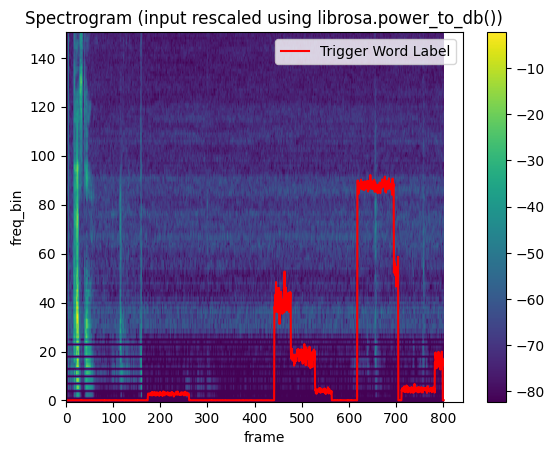

In [67]:
# now graph 
plot_spectrogram(padded_spec[0],label_out.detach().numpy(), title=None, ylabel='freq_bin', aspect='auto', xmax=None)

In [73]:
# print realtime detection

def real_time_detection(label_out,cut_off =0.8,    real_time = False):
    '''
    cut_off -  the probability above which a time step must be for the system to be triggered
    
    '''

    label_out_bool = torch.where(label_out > cut_off, 1.0, 0.0)

    grad = torch.gradient(label_out_bool[0])



    # Loop through label_out - delaying 
    spec_time = label_out.shape[-1]
    time_fraction = 10/spec_time

    #functionality not implimented yet to stop multiple chimes 
    delay= False 


    I_lag = 0
    for I in range(0,spec_time):

        if real_time == True:
            time.sleep(time_fraction)

        t_last= int(I_lag*time_fraction)
        t_now = int(I*time_fraction) 
        #print(t_last,t_now)

        if label_out[0,I] > 0.8 and delay == False:
            print(f'Chime - trigger word detected at {I * time_fraction} seconds, index {I}')

            delay = True

        if grad[0][I] > 0 and delay == True:
            #set delay back to false
            print(f'Chime - trigger word un detected detected at {I * time_fraction} seconds, index {I}')
            delay =False



        if  t_last < t_now:
            print(I *time_fraction , ' seconds')

        if I>0:
            I_lag = I    

    print(I *time_fraction , ' seconds')    
real_time_detection(label_out,real_time=False) 

1.0036363636363637  seconds
2.0  seconds
3.0036363636363634  seconds
4.0  seconds
5.003636363636364  seconds
6.0  seconds
7.003636363636364  seconds
Chime - trigger word detected at 7.709090909090909 seconds, index 1060
Chime - trigger word un detected detected at 7.709090909090909 seconds, index 1060
Chime - trigger word detected at 7.716363636363637 seconds, index 1061
8.0  seconds
9.003636363636364  seconds
9.992727272727272  seconds


# Testing inferencing

Build functions to padd a given wave recordign to the 10 second limit

In [2]:
import torch
model = torch.load('model_test_mel_100_epochs')

# Test recordign

In [3]:
!pip install sounddevice
!pip install scipy
!pip install wavio

                                              0.0/199.7 kB ? eta -:--:--
     -------------------------------        163.8/199.7 kB 5.0 MB/s eta 0:00:01
     -------------------------------------- 199.7/199.7 kB 4.0 MB/s eta 0:00:00


In [120]:
# import required libraries
import sounddevice as sd
from scipy.io.wavfile import write
import wavio as wv

folder = 'user_generated_recordings/'

# Sampling frequency
freq = 16000
 
# Recording duration
duration = 10
channels = 1
 
# Start recorder with the given values
# of duration and sample frequency
recording = sd.rec(int(duration * freq),
                   samplerate=freq, channels=1)
 
# Record audio for the given number of seconds

time.sleep(duration)
 
# This will convert the NumPy array to an audio
# file with the given sampling frequency



In [121]:
write(folder+ "recording0_11.wav", freq, recording)

In [4]:
import torchaudio
from IPython.display import Audio
#play clip

waveform, rsr  = torchaudio.load(folder + 'recording0_11.wav')
Audio(waveform.numpy()[0], rate=rsr)

NameError: name 'folder' is not defined

In [123]:
print(rsr)
print(waveform.shape)

16000
torch.Size([1, 160000])


# Create padding

In [124]:

offset = 0

padded_waveform = torch.zeros(1,10*rsr)

l_waveform = waveform.shape[1]
padded_waveform[:,offset:offset+l_waveform] = waveform

padded_waveform.shape

torch.Size([1, 160000])

# Apply spectrogram

In [125]:
import torchaudio.transforms as T

#these will have to be hard coded in
number_frequencies = 151
number_time_steps = 400
sample_rate = rsr
spectrogram =  T.MelSpectrogram(sample_rate,
                                n_fft=number_time_steps,
                                n_mels = number_frequencies,
                                normalized = True)

spec = spectrogram(padded_waveform)

print(spec.shape)




torch.Size([1, 151, 801])


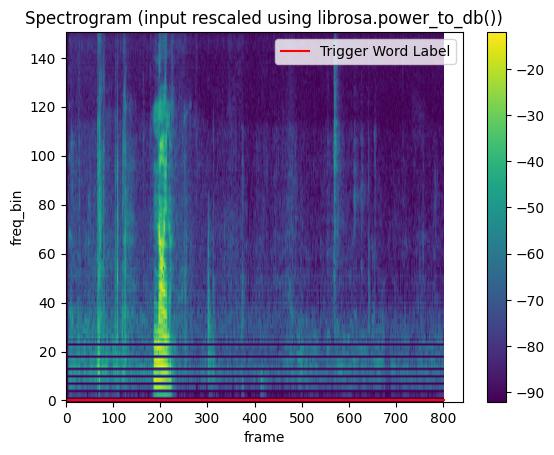

In [126]:
# plot 
from data_loading import plot_spectrogram 
label = torch.zeros(1,spec.shape[-1])

plot_spectrogram(spec[0],label, title=None, ylabel='freq_bin', aspect='auto', xmax=None)

# Now inference

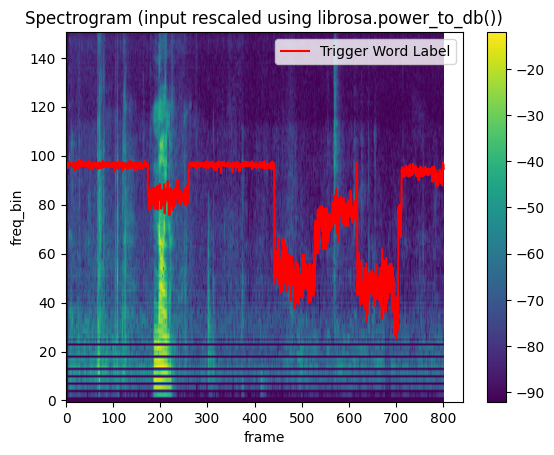

In [127]:
label_out = model(spec)

plot_spectrogram(spec[0],label_out.detach().numpy(), title=None, ylabel='freq_bin', aspect='auto', xmax=None)

In [128]:
print(torch.max(label_out),torch.min(label_out))


tensor(0.9828, grad_fn=<MaxBackward1>) tensor(0.2543, grad_fn=<MinBackward1>)


#  Reaction to probability
If probability is > 0.8 for a period then perform an action -   need to this to happen over time - which is tricky


Added in gradient to stop multiple chimes 

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [69]:
#calculate gradient 
cut_off =0.8

label_out_bool = torch.where(label_out > cut_off, 1.0, 0.0)

grad = torch.gradient(label_out_bool[0])



# Loop through label_out - delaying 
import time 
spec_time = label_out.shape[-1]
time_fraction = 10/spec_time

#functionality not implimented yet to stop multiple chimes 
delay= False 

#so this happens in real time  or not - or not is for testing portion 
real_time = False

I_lag = 0
for I in range(0,spec_time):
    
    if real_time == True:
        time.sleep(time_fraction)
    
    t_last= int(I_lag*time_fraction)
    t_now = int(I*time_fraction) 
    #print(t_last,t_now)
    
    if label_out[0,I] > 0.8 and delay == False:
        print(f'Chime - trigger word detected at {I * time_fraction} seconds, index {I}')
        
        delay = True
    
    if grad[0][I] > 0 and delay == True:
        #set delay back to false
        print(f'Chime - trigger word un detected detected at {I * time_fraction} seconds, index {I}')
        delay =False

    
    
    if  t_last < t_now:
        print(I *time_fraction , ' seconds')

    if I>0:
        I_lag = I    
        
print(I *time_fraction , ' seconds')

1.0036363636363637  seconds
2.0  seconds
3.0036363636363634  seconds
4.0  seconds
5.003636363636364  seconds
6.0  seconds
7.003636363636364  seconds
Chime - trigger word detected at 7.709090909090909 seconds, index 1060
Chime - trigger word un detected detected at 7.709090909090909 seconds, index 1060
Chime - trigger word detected at 7.716363636363637 seconds, index 1061
8.0  seconds
9.003636363636364  seconds
9.992727272727272  seconds


In [77]:
I_lag

1374

In [85]:
time_fraction

0.0007272727272727272